In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as img

import json

from torchvision import transforms as T
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms.functional as F

import torch
import os

import numpy as np


from torch.utils.data import DataLoader
from tqdm import tqdm

import cv2
from cv2 import cv2 as cv2_ext

import clip
from PIL import Image

import torch.nn as nn

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix

from prettytable import PrettyTable
from CLIP_utils import get_features, get_lr, train_model, compute_accuracy

import optuna
from enum import IntEnum


import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

In [2]:
from classes.transforms.CropCenter import CropCenter
from classes.transforms.ScaleMaxSideToSize import ScaleMaxSideToSize
#from classes.transforms.Binarize import Binarize
#from classes.OCR_Wrapper import OCR_Wrapper
from classes.dataset.HatefulMemesDataset import HatefulMemesDataset
from classes.dataset.FeaturesDataset import FeaturesDataset

In [3]:
CROP_SIZE=224

In [5]:
#del OCR_Wrapper
class OCR_Wrapper(object):
    def __init__(self, action, transform):
        self.action = action
        self.transform = transform

    def __call__(self, path):
        image = cv2_ext.imread(path, cv2_ext.COLOR_BGR2RGB)
        image = self.transform(image)
        return self.action(image)
    
#del Binarize
#from classes.transforms.Binarize import Binarize


class Binarize(object):
    def __init__(self, thresh, maxval, type_):
        self.thresh = thresh
        self.maxval = maxval
        self.type_ = type_

    def __call__(self, sample):
        img = sample
        img = cv2_ext.cvtColor(img, cv2_ext.COLOR_BGR2GRAY)
        _, sample = cv2_ext.threshold(img, thresh=self.thresh, maxval=self.maxval, type=self.type_)
      
        return sample

In [6]:
ocr_wrapper = OCR_Wrapper(
    action=lambda image: pytesseract.image_to_string(image).replace('\n', ' '), 
    transform=T.Compose([
        ScaleMaxSideToSize(CROP_SIZE),
        CropCenter(CROP_SIZE),
        Binarize(thresh=241, maxval=39, type_=cv2_ext.THRESH_BINARY_INV),
]))

In [7]:
ocr_wrapper(r'E:\coding\MADE\3_graduation\ocr\01243.png')


'when youth why sat yuutl Une  ed  Hrisuty Kuper is v0  '

In [8]:
data_dir = r'E:\datasets\MADE\3_graduation\parthplc\archive\data\\'

In [9]:
train_path = data_dir + 'train.jsonl'
dev_path = data_dir + 'dev.jsonl'

train_data = pd.read_json(train_path, lines=True)
test_data = pd.read_json(dev_path, lines=True)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:

model, preprocess = clip.load("ViT-B/32", device=device)

#### Предобработка изображений

In [12]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

In [13]:
transforms = T.Compose([
    ScaleMaxSideToSize(CROP_SIZE),
    CropCenter(CROP_SIZE),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])

In [14]:
train_dataset = HatefulMemesDataset(train_path, transforms)
val_dataset = HatefulMemesDataset(dev_path, transforms)

#### Извлекаем признаки из текста и картинок

In [15]:
features_train, labels_train = get_features(model, train_dataset, ocr_wrapper)
features_val, labels_val = get_features(model, val_dataset, ocr_wrapper)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:05<00:00, 13.16s/it]


In [16]:
features_train_dataset = FeaturesDataset(features_train, labels_train)
features_val_dataset = FeaturesDataset(features_val, labels_val)

In [27]:
best_model = torch.load(open('classifier_13_0.654.ckpt', 'rb'))
print(best_model)

Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)


In [28]:
best_model.eval()
for i_step, (x, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x)

acc_score = accuracy_score(np.array([x.item() for x in labels_val]), torch.max(prediction, 1)[1])
auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction[:,1].detach().numpy())

print(acc_score, auc_score)

0.624 0.6384800000000002


0.6384800000000002


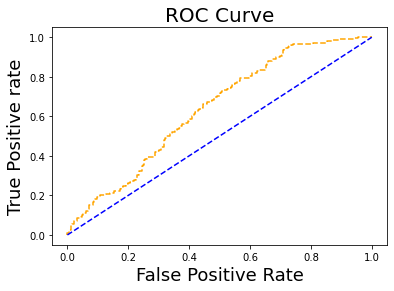

In [29]:
fpr, tpr, thresh = roc_curve(labels_val, prediction[:,1].detach().numpy(), pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction[:,1].detach().numpy())
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

In [30]:
best_model.eval()
for i_step, (x, y) in enumerate(DataLoader(features_train_dataset, batch_size=50000)):
    prediction = best_model(x)

acc_score = accuracy_score(np.array([x.item() for x in labels_train]), torch.max(prediction, 1)[1])
auc_score = roc_auc_score(np.array([x.item() for x in labels_train]), prediction[:,1].detach().numpy())

print(acc_score, auc_score)

0.6921176470588235 0.8482892465032337


0.8482892465032337


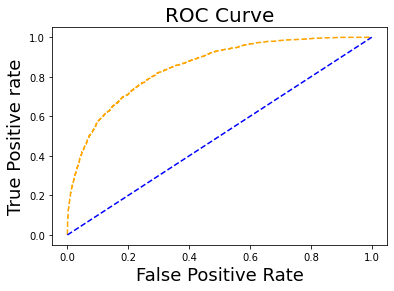

In [31]:
fpr, tpr, thresh = roc_curve(labels_train, prediction[:,1].detach().numpy(), pos_label=1)

random_probs = [0 for i in range(len(labels_train))]
p_fpr, p_tpr, _ = roc_curve(labels_train, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_train, prediction[:,1].detach().numpy())
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

In [32]:
input_shape = 1024
num_classes = 2

In [33]:
#torch.manual_seed(0)# 0.666 0.706048
torch.manual_seed(1024) #0.662 0.724256
#torch.manual_seed(567)# 0.658 0.699472
#torch.manual_seed(12) #0.656 0.7045600000000001
#torch.manual_seed(2048) #0.678 0.7083360000000001
#torch.manual_seed(1)# 0.678 0.716224
#torch.manual_seed(215)

shape = 256
nn_model = nn.Sequential(
            nn.Linear(input_shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, num_classes),
            )

print(nn_model)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

loss_history, train_history, val_history, best_model_name = train_model(
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 500, scheduler)
print('end!')


Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)
Epoch: 0 lr: 0.010000; Average loss: 0.699690, Train accuracy: 0.612235, Val accuracy: 0.582000
Epoch: 1 lr: 0.010000; Average loss: 0.618513, Train accuracy: 0.668235, Val accuracy: 0.502000
Epoch: 2 lr: 0.010000; Average loss: 0.563589, Train accuracy: 0.704824, Val accuracy: 0.636000
Epoch: 3 lr: 0.010000; Average loss: 0.549696, Train accuracy: 0.712000, Val accuracy: 0.618000
Epoch: 4 lr: 0.010000; Average loss: 0.533811, Train accuracy: 0.732941, Val accuracy: 0.648000
saved classifier_4_0.64

Epoch: 79 lr: 0.001678; Average loss: 0.040258, Train accuracy: 0.985294, Val accuracy: 0.632000
Epoch: 80 lr: 0.001678; Average loss: 0.035543, Train accuracy: 0.989059, Val accuracy: 0.624000
Epoch: 81 lr: 0.001678; Average loss: 0.039157, Train accuracy: 0.985176, Val accuracy: 0.632000
Epoch: 82 lr: 0.001678; Average loss: 0.032121, Train accuracy: 0.988941, Val accuracy: 0.628000
Epoch: 83 lr: 0.001678; Average loss: 0.029253, Train accuracy: 0.989176, Val accuracy: 0.626000
Epoch: 84 lr: 0.001678; Average loss: 0.035254, Train accuracy: 0.988118, Val accuracy: 0.634000
Epoch: 85 lr: 0.001678; Average loss: 0.035466, Train accuracy: 0.988588, Val accuracy: 0.622000
Epoch: 86 lr: 0.001678; Average loss: 0.029806, Train accuracy: 0.989647, Val accuracy: 0.608000
Epoch: 87 lr: 0.001678; Average loss: 0.032638, Train accuracy: 0.988471, Val accuracy: 0.622000
Epoch: 88 lr: 0.001678; Average loss: 0.030851, Train accuracy: 0.989176, Val accuracy: 0.624000
Epoch: 89 lr: 0.001342; Averag

Epoch: 164 lr: 0.000281; Average loss: 0.013924, Train accuracy: 0.994824, Val accuracy: 0.622000
Epoch: 165 lr: 0.000281; Average loss: 0.013010, Train accuracy: 0.995294, Val accuracy: 0.620000
Epoch: 166 lr: 0.000281; Average loss: 0.016963, Train accuracy: 0.994353, Val accuracy: 0.620000
Epoch: 167 lr: 0.000281; Average loss: 0.015111, Train accuracy: 0.994706, Val accuracy: 0.622000
Epoch: 168 lr: 0.000281; Average loss: 0.012956, Train accuracy: 0.996353, Val accuracy: 0.614000
Epoch: 169 lr: 0.000225; Average loss: 0.014042, Train accuracy: 0.996000, Val accuracy: 0.614000
Epoch: 170 lr: 0.000225; Average loss: 0.013472, Train accuracy: 0.995412, Val accuracy: 0.612000
Epoch: 171 lr: 0.000225; Average loss: 0.016318, Train accuracy: 0.994941, Val accuracy: 0.618000
Epoch: 172 lr: 0.000225; Average loss: 0.013787, Train accuracy: 0.995765, Val accuracy: 0.616000
Epoch: 173 lr: 0.000225; Average loss: 0.010271, Train accuracy: 0.997176, Val accuracy: 0.614000
Epoch: 174 lr: 0.000

Epoch: 248 lr: 0.000047; Average loss: 0.013386, Train accuracy: 0.995647, Val accuracy: 0.618000
Epoch: 249 lr: 0.000038; Average loss: 0.011952, Train accuracy: 0.996471, Val accuracy: 0.620000
Epoch: 250 lr: 0.000038; Average loss: 0.011416, Train accuracy: 0.995765, Val accuracy: 0.620000
Epoch: 251 lr: 0.000038; Average loss: 0.009874, Train accuracy: 0.997294, Val accuracy: 0.620000
Epoch: 252 lr: 0.000038; Average loss: 0.010372, Train accuracy: 0.996235, Val accuracy: 0.618000
Epoch: 253 lr: 0.000038; Average loss: 0.011683, Train accuracy: 0.996353, Val accuracy: 0.614000
Epoch: 254 lr: 0.000038; Average loss: 0.012498, Train accuracy: 0.995647, Val accuracy: 0.612000
Epoch: 255 lr: 0.000038; Average loss: 0.012535, Train accuracy: 0.996118, Val accuracy: 0.618000
Epoch: 256 lr: 0.000038; Average loss: 0.013590, Train accuracy: 0.995059, Val accuracy: 0.618000
Epoch: 257 lr: 0.000038; Average loss: 0.009980, Train accuracy: 0.996824, Val accuracy: 0.618000
Epoch: 258 lr: 0.000

Epoch: 333 lr: 0.000006; Average loss: 0.011996, Train accuracy: 0.996353, Val accuracy: 0.620000
Epoch: 334 lr: 0.000006; Average loss: 0.013262, Train accuracy: 0.995765, Val accuracy: 0.616000
Epoch: 335 lr: 0.000006; Average loss: 0.013122, Train accuracy: 0.995765, Val accuracy: 0.614000
Epoch: 336 lr: 0.000006; Average loss: 0.009678, Train accuracy: 0.997176, Val accuracy: 0.614000
Epoch: 337 lr: 0.000006; Average loss: 0.011921, Train accuracy: 0.995882, Val accuracy: 0.616000
Epoch: 338 lr: 0.000006; Average loss: 0.010275, Train accuracy: 0.996824, Val accuracy: 0.618000
Epoch: 339 lr: 0.000005; Average loss: 0.013046, Train accuracy: 0.996118, Val accuracy: 0.614000
Epoch: 340 lr: 0.000005; Average loss: 0.010061, Train accuracy: 0.996588, Val accuracy: 0.616000
Epoch: 341 lr: 0.000005; Average loss: 0.010131, Train accuracy: 0.996941, Val accuracy: 0.614000
Epoch: 342 lr: 0.000005; Average loss: 0.010437, Train accuracy: 0.996588, Val accuracy: 0.618000
Epoch: 343 lr: 0.000

Epoch: 418 lr: 0.000001; Average loss: 0.012814, Train accuracy: 0.995176, Val accuracy: 0.618000
Epoch: 419 lr: 0.000001; Average loss: 0.010603, Train accuracy: 0.997059, Val accuracy: 0.616000
Epoch: 420 lr: 0.000001; Average loss: 0.013372, Train accuracy: 0.995412, Val accuracy: 0.616000
Epoch: 421 lr: 0.000001; Average loss: 0.011559, Train accuracy: 0.995765, Val accuracy: 0.620000
Epoch: 422 lr: 0.000001; Average loss: 0.011978, Train accuracy: 0.996353, Val accuracy: 0.614000
Epoch: 423 lr: 0.000001; Average loss: 0.010678, Train accuracy: 0.996941, Val accuracy: 0.614000
Epoch: 424 lr: 0.000001; Average loss: 0.012234, Train accuracy: 0.995059, Val accuracy: 0.618000
Epoch: 425 lr: 0.000001; Average loss: 0.009188, Train accuracy: 0.996824, Val accuracy: 0.618000
Epoch: 426 lr: 0.000001; Average loss: 0.011009, Train accuracy: 0.996235, Val accuracy: 0.618000
Epoch: 427 lr: 0.000001; Average loss: 0.010414, Train accuracy: 0.996118, Val accuracy: 0.616000
Epoch: 428 lr: 0.000

In [34]:
print("best model:", best_model_name)

best model: classifier_24_0.652.ckpt


In [35]:
best_model = torch.load(open(best_model_name, 'rb'))
print(best_model)

Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)


In [36]:
print(compute_accuracy(best_model, DataLoader(features_val_dataset, batch_size=500)))

best_model.eval()
for i_step, (x, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x)
    
prediction = prediction[:,1].detach().numpy()

auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction)
print(auc_score)

0.652
0.676624


0.676624


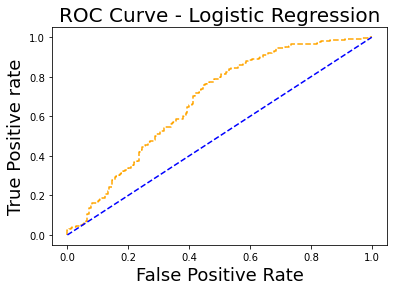

In [37]:
fpr, tpr, thresh = roc_curve(labels_val, prediction, pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction)
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve - Logistic Regression', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();